In [37]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("psvishnu/pennfudan-database-for-pedestrian-detection-zip")

# print("Path to dataset files:", path)

In [4]:
# !mv /root/.cache/kagglehub/datasets/psvishnu/pennfudan-database-for-pedestrian-detection-zip/versions/1 /content/pennfudan-database-for-pedestrian-detection-zip/

In [8]:
img_dir = '/home/abuzarmahmood/projects/pulakat_lab/auto_slide/data/labelled_images/images/'
mask_dir = '/home/abuzarmahmood/projects/pulakat_lab/auto_slide/data/labelled_images/masks/'
images = sorted(os.listdir(img_dir))
masks = sorted(os.listdir(mask_dir))

In [14]:
idx = 0
img = Image.open(img_dir + images[idx]).convert("RGB")
mask = Image.open(mask_dir + masks[idx])

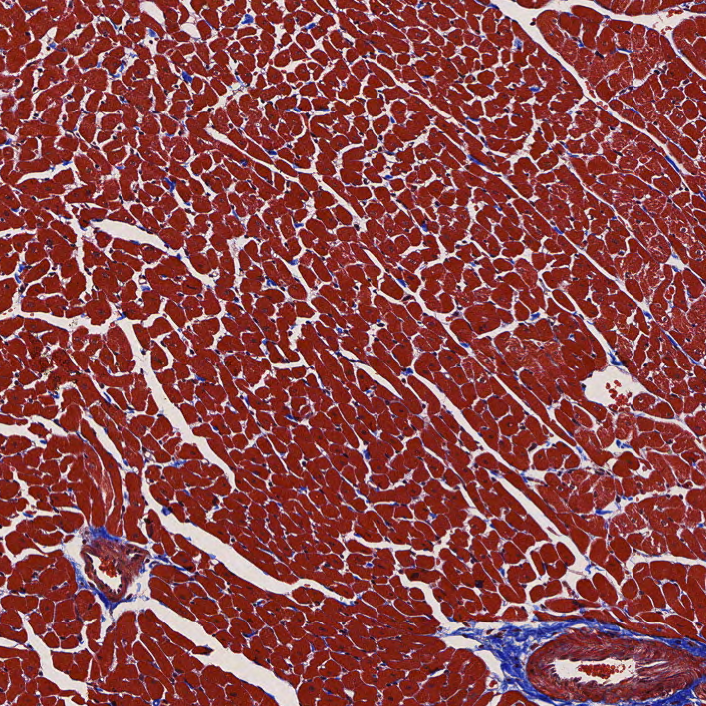

In [15]:
img

In [11]:
np.unique(mask)

array([  0, 255], dtype=uint8)

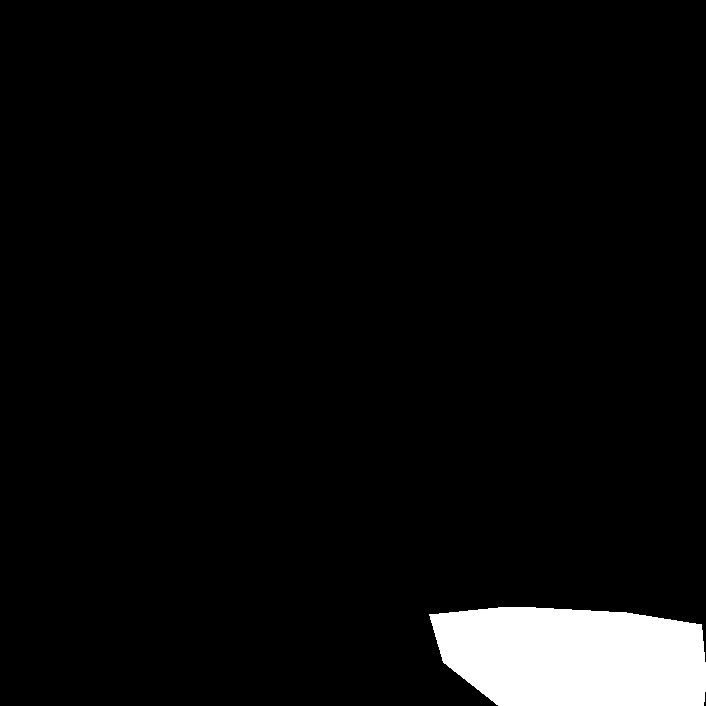

In [18]:
Image.fromarray(np.array(mask)//255 == 1)

In [30]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open(img_dir + self.imgs[idx]).convert("RGB")
        mask = Image.open(mask_dir + self.masks[idx])
        mask = np.array(mask) // 255
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [20]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/abuzarmahmood/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 44.3MB/s]


In [21]:
transform = T.ToTensor()

In [22]:
def custom_collate(data):
  return data

In [23]:
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [31]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [34]:
params = [p for p in model.parameters() if p.requires_grad]

In [35]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [38]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in trange(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

  0%|                                                                                            | 0/30 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.2424, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0299, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.8695, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6618, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, grad_fn=<DivBackward0>)}


  0%|                                                                                            | 0/30 [03:01<?, ?it/s]


IndexError: list index out of range

In [ ]:
plt.plot(all_train_losses)

In [ ]:
plt.plot(all_val_losses)

In [ ]:
model.eval()
img = Image.open(img_dir + images[0]).convert("RGB")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [ ]:
img

In [ ]:
pred

In [ ]:
n_preds = len(pred[0]["masks"])
fig, ax = plt.subplots(1, n_preds, figsize=(5*n_preds,5))
for i in range(n_preds):
    ax[i].imshow((pred[0]["masks"][i].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [ ]:
img.size

In [ ]:
all_preds = np.stack([(pred[0]["masks"][i].cpu().detach().numpy() * 255).astype("uint8").squeeze() for i in range(n_preds)])

In [ ]:
plt.imshow(all_preds.mean(axis = 0))
plt.colorbar()